In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import class_weight
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations, df

In [4]:
images, annotations, df = load_data("../../../../images/", '../../../../emo-at-cap.csv')

In [5]:
import pickle

In [6]:
with open('emotion_features.pl', 'rb') as f:
    emotion_features = pickle.load(f)

In [7]:
sentiment = df['sentiment'].values

In [8]:
with open('gender_features.pl', 'rb') as f:
    gender_features = pickle.load(f)

# Processing of data

In [9]:
import nltk

In [10]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
one_hot_enc = OneHotEncoder()
sentiment = one_hot_enc.fit_transform(sentiment.reshape(-1,1))

In [13]:
sentiment = sentiment.toarray()

In [14]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [15]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [16]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.hstack(tokenized)), np.hstack(tokenized))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=["'" ',' '-' ... 'youth' 'исходный' 'текст'], y=['the' 'man' 'is' ... 'with' 'some' 'clothes'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [17]:
frequency = sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

In [18]:
frequency

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [19]:
len(unique_tokens)

2162

In [20]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [21]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [22]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [23]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [24]:
padded_sentences = padd(tokenized, pad_token, start_token, end_token, maxlen=10)

In [25]:
np.mean([len(i) for i in padded_sentences])

12.0

In [26]:
indexed = list(map(lambda x: [vocab[i] for i in x],padded_sentences))

In [27]:
images.shape

(3840, 224, 224, 3)

In [28]:
len(class_weights)

2162

In [29]:
class_weights = list(class_weights)
class_weights.insert(0, 1)
class_weights.insert(1, 1)
class_weights.insert(2, 1)

In [30]:
len(class_weights), len(vocab)

(2165, 2165)

In [31]:
class_weights[:4]

[1, 1, 1, 0.21013259327782918]

In [32]:
class_weights = np.array(class_weights)

In [33]:
class_weights.shape

(2165,)

# Model with transfer learning

In [34]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [35]:
import tensorflow.keras.applications as apps


In [36]:
class ConvEncoder(tf.keras.Model):
    def __init__(self, trainable=False):
        super(ConvEncoder, self).__init__()
        #loading pretrained encoder
        self.encoder = tf.keras.models.load_model('encoder.h5')
        self.encoder.trainable=trainable
        
        #on top layers
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        
    def call(self, input):
        features = self.encoder(input)
        return self.dense1(features)

In [37]:
conv_encoder = ConvEncoder()

In [38]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [39]:
conv_res

<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
array([[0.        , 0.03138161, 0.90139997, 0.1530464 , 0.        ,
        0.        , 0.4331551 , 1.448478  , 0.        , 0.        ,
        0.54014516, 0.        , 0.2345208 , 0.        , 1.7599672 ,
        2.2833786 , 0.        , 0.6446878 , 0.        , 0.        ,
        1.9025598 , 0.08810303, 0.11903951, 0.        , 0.10451436,
        1.6270452 , 1.5704622 , 0.        , 0.17368805, 0.94622743,
        0.7156482 , 0.92243934, 0.49381304, 0.        , 0.32112542,
        0.21971312, 0.9188378 , 0.        , 0.34695274, 1.339732  ,
        0.        , 2.4649563 , 0.8559554 , 2.1452699 , 0.27313313,
        0.609342  , 2.0705836 , 0.        , 0.        , 0.42723823,
        0.        , 0.20286131, 0.9459039 , 0.        , 0.        ,
        0.        , 0.        , 1.4409425 , 1.0246812 , 0.        ,
        0.3989364 , 0.        , 0.        , 0.49472904, 1.1246147 ,
        0.        , 0.        , 0.        , 0.        , 0.5746299 

### LSTM model

### making w2v embeddings

In [40]:
!pip install gensim

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [41]:
import gensim.downloader as api

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [42]:
w2v_embeddings = api.load('word2vec-google-news-300')

In [43]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('{} words are out of vocabulary：'.format(count))
    return emb_matrix


In [44]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

22 words are out of vocabulary：


### attention

In [45]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### building model

In [46]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, units=512, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.units = units
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.lstm = tf.keras.layers.LSTM(units=self.units, return_state=True, return_sequences=True, name='lstm_decoder', 
                                         recurrent_dropout=0.1,recurrent_initializer='glorot_uniform')
        self.intermidiate_dense = tf.keras.layers.Dense(units=self.units, activation='relu')
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        self.dense_sentiment = tf.keras.layers.Dense(self.units, activation='relu')
        self.dense_gender = tf.keras.layers.Dense(self.units, activation='relu')
        self.attention = BahdanauAttention(self.units)

    def call(self, input, features, hidden, state_c, emo_feature, sentiment_feature, gender_feature):
        embedded = self.dropout(self.embeddings(input))
        context_vector, attention_weights = self.attention(features, hidden)
        processed_sentiment = self.dense_sentiment(sentiment_feature)
        processed_gender = self.dense_gender(gender_feature)
        concated = tf.concat([tf.expand_dims(context_vector, 1), embedded,\
                              tf.expand_dims(emo_feature, 1),tf.expand_dims(processed_sentiment, 1),tf.expand_dims(processed_gender, 1)], axis=-1)
        result_lstm, state_h, state_c = self.lstm(concated, initial_state=[hidden, state_c])
        intermidiate_dense = self.intermidiate_dense(result_lstm)
        intermidiate_dense = tf.reshape(intermidiate_dense, (-1, intermidiate_dense.shape[2]))
        logits = self.output_dense(intermidiate_dense)
        return logits, state_h, state_c, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [47]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), 256, w2v_embeddings, dim=300)

### emotion decoder

In [48]:
class EmotionEncoder(tf.keras.Model):
    def __init__(self, units=512):
        super(EmotionEncoder, self).__init__()
        self.h = tf.keras.layers.Dense(units=units, activation='relu')
        self.c = tf.keras.layers.Dense(units=units, activation='relu')

    def call(self, emotion_feature):
        
        return self.h(emotion_feature), self.c(emotion_feature)
 

In [49]:
emotion_encoder = EmotionEncoder(256)

In [50]:
emotion_encoder(np.expand_dims(emotion_features[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
 array([[0.        , 0.0025846 , 0.        , 0.        , 0.        ,
         0.03784531, 0.02918529, 0.        , 0.04235475, 0.01632023,
         0.00670166, 0.        , 0.02574178, 0.        , 0.0110131 ,
         0.03501929, 0.01532016, 0.        , 0.00672387, 0.        ,
         0.03641343, 0.        , 0.02301671, 0.0515212 , 0.03914176,
         0.        , 0.        , 0.        , 0.03998164, 0.02858276,
         0.061079  , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.00178318, 0.        , 0.        ,
         0.        , 0.        , 0.0127151 , 0.        , 0.01252801,
         0.        , 0.02421342, 0.        , 0.03298398, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.08522198,
         0.03160135, 0.        , 0.        , 0.        , 0.02179   ,
         0.01332078, 0.        , 0.        , 0.04554076, 0.        ,
         0.01975337, 0.01536281, 0.        , 0.     

### Training

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)
with_weights = False

In [53]:
epochs = 30
batch_size = 64
patience_epochs = 2

In [54]:
def loss_function(real, pred, loss_weights):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_weights = tf.cast(loss_weights, dtype=loss_.dtype)
        loss_*=loss_weights
        return loss_

In [55]:
@tf.function
def train_step(image, target, emo_feature, sentiment_feature,gender_feature, lengths, optimizer):
    with tf.GradientTape() as tape:
        features = conv_encoder(image)
        hidden, state_c = emotion_encoder(emo_feature)

        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, hidden, state_c, _ = lstm_decoder(dec_input, features, hidden, state_c,emo_feature,sentiment_feature,gender_feature)
            weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
            weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
            batched_loss.append(loss_function(target[:, t], result, weights))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables + emotion_encoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [56]:
@tf.function
def evaluate(image, target,emo_feature,sentiment_feature,gender_feature, lengths, optimizer):
    hidden, state_c = emotion_encoder(emo_feature)

    features = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, hidden, state_c, _ = lstm_decoder(dec_input, features, hidden, state_c, emo_feature,sentiment_feature,gender_feature)
        weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
        weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
        batched_loss.append(loss_function(target[:, t], result, weights))
    
    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)
    perplexity = tf.exp(loss)


    return loss, perplexity

In [57]:
gender_features = [np.array(i) for i in gender_features]

In [58]:
train_images, val_images, train_sequences, val_sequences, train_emo, val_emo,\
train_sen, val_sen, train_gen, val_gen =  train_test_split(images, indexed, emotion_features, 
                                                           sentiment,gender_features, test_size=0.2, random_state=10)
val_images, test_images, val_sequences, test_sequences, val_emo, test_emo, val_sen, test_sen, val_gen, test_gen =  train_test_split(val_images, val_sequences,val_emo,\
                                                                                                                 val_sen, val_gen, test_size=0.5, random_state=10)




In [59]:
train_length = (np.array(train_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [60]:
val_length = (np.array(val_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [61]:
test_length = (np.array(test_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [62]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size)).astype('float32')
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size)).astype('float32')
val_images = np.array(np.array_split(val_images, len(val_images)//batch_size)).astype('float32')

train_emo = np.array(np.array_split(train_emo, len(train_emo)//batch_size)).astype('float32')
test_emo = np.array(np.array_split(test_emo, len(test_emo)//batch_size)).astype('float32')
val_emo = np.array(np.array_split(val_emo, len(val_emo)//batch_size)).astype('float32')

train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
val_sequences = np.array(np.array_split(val_sequences, len(val_sequences)//batch_size))

train_length = np.array(np.array_split(train_length, len(train_length)//batch_size)).astype('float32')
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size)).astype('float32')
val_length = np.array(np.array_split(val_length, len(val_length)//batch_size)).astype('float32')

train_sen = np.array(np.array_split(train_sen, len(train_sen)//batch_size)).astype('float32')
test_sen = np.array(np.array_split(test_sen, len(test_sen)//batch_size)).astype('float32')
val_sen = np.array(np.array_split(val_sen, len(val_sen)//batch_size)).astype('float32')

train_gen = np.array(np.array_split(train_gen, len(train_gen)//batch_size)).astype('float32')
test_gen = np.array(np.array_split(test_gen, len(test_gen)//batch_size)).astype('float32')
val_gen = np.array(np.array_split(val_gen, len(val_gen)//batch_size)).astype('float32')

In [63]:
train_images.shape, train_sequences.shape, train_length.shape, train_emo.shape, train_sen.shape, train_gen.shape

((48, 64, 224, 224, 3),
 (48, 64, 12),
 (48, 64),
 (48, 64, 7),
 (48, 64, 3),
 (48, 64, 5))

In [64]:
!pip install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [65]:
if not with_weights:
    class_weights = np.array([1 for i in range(len(class_weights))])

In [66]:
from tqdm import tqdm

In [67]:
train_loss = []
train_perplexity = []
val_loss = []
val_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_val_loss = 0
    epoch_val_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length, batched_train_emo, batched_train_sen, batched_train_gen in tqdm(zip(train_images,train_sequences,train_length, train_emo, train_sen, train_gen)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_emo,batched_train_sen,batched_train_gen, batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_val_images, batch_val_sequences, batched_val_length, batched_test_emo, batched_val_sen, batched_val_gen in zip(val_images,val_sequences,val_length, val_emo, val_sen, val_gen):
        batched_val_loss, batched_val_perplexity = evaluate(batch_val_images, batch_val_sequences, batched_test_emo,batched_val_sen,batched_val_gen, batched_val_length, optimizer)
        epoch_val_loss+=batched_val_loss
        epoch_val_perplexity+=batched_val_perplexity
    epoch_val_loss = epoch_val_loss/val_images.shape[0]
    epoch_val_perplexity = epoch_val_perplexity/val_images.shape[0]
    val_perplexity.append(epoch_val_perplexity)
    val_loss.append(epoch_val_loss)
    print('Validation loss : {}; Validation perplexity : {}'.format(epoch_val_loss,epoch_val_perplexity))
    if len(val_loss)>=2 and val_loss[-2]<val_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in validation loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

48it [00:27,  1.72it/s]


Finished epoch 0; Train loss : 7.694709777832031; Train perplexity : 3119.995849609375
Validation loss : 6.352762699127197; Validation perplexity : 583.6815185546875


48it [00:08,  5.49it/s]


Finished epoch 1; Train loss : 5.9185943603515625; Train perplexity : 377.8361511230469
Validation loss : 5.767107009887695; Validation perplexity : 323.7874450683594


48it [00:08,  5.51it/s]


Finished epoch 2; Train loss : 5.6143717765808105; Train perplexity : 277.02032470703125
Validation loss : 5.600162506103516; Validation perplexity : 273.8666076660156


48it [00:08,  5.51it/s]


Finished epoch 3; Train loss : 5.4151225090026855; Train perplexity : 226.93878173828125
Validation loss : 5.458787441253662; Validation perplexity : 237.2411346435547


48it [00:08,  5.48it/s]


Finished epoch 4; Train loss : 5.250242233276367; Train perplexity : 192.53773498535156
Validation loss : 5.344117641448975; Validation perplexity : 211.3964385986328


48it [00:08,  5.49it/s]


Finished epoch 5; Train loss : 5.1047749519348145; Train perplexity : 166.56712341308594
Validation loss : 5.232616901397705; Validation perplexity : 189.14794921875


48it [00:08,  5.50it/s]


Finished epoch 6; Train loss : 4.962453365325928; Train perplexity : 144.5670928955078
Validation loss : 5.125565528869629; Validation perplexity : 170.06298828125


48it [00:08,  5.48it/s]


Finished epoch 7; Train loss : 4.821927547454834; Train perplexity : 125.64090728759766
Validation loss : 4.98779296875; Validation perplexity : 148.9055938720703


48it [00:08,  5.47it/s]


Finished epoch 8; Train loss : 4.67743444442749; Train perplexity : 108.8249740600586
Validation loss : 4.891567707061768; Validation perplexity : 135.25714111328125


48it [00:08,  5.48it/s]


Finished epoch 9; Train loss : 4.537328720092773; Train perplexity : 94.6628646850586
Validation loss : 4.77964448928833; Validation perplexity : 121.15909576416016


48it [00:08,  5.50it/s]


Finished epoch 10; Train loss : 4.405544757843018; Train perplexity : 82.96634674072266
Validation loss : 4.670413494110107; Validation perplexity : 108.8749771118164


48it [00:08,  5.51it/s]


Finished epoch 11; Train loss : 4.283114910125732; Train perplexity : 73.42601013183594
Validation loss : 4.566986083984375; Validation perplexity : 98.382568359375


48it [00:08,  5.51it/s]


Finished epoch 12; Train loss : 4.1694746017456055; Train perplexity : 65.56155395507812
Validation loss : 4.467844486236572; Validation perplexity : 89.30883026123047


48it [00:08,  5.49it/s]


Finished epoch 13; Train loss : 4.068596839904785; Train perplexity : 59.2631721496582
Validation loss : 4.38916540145874; Validation perplexity : 82.68392181396484


48it [00:08,  5.51it/s]


Finished epoch 14; Train loss : 3.97251296043396; Train perplexity : 53.860652923583984
Validation loss : 4.321807861328125; Validation perplexity : 77.41503143310547


48it [00:08,  5.51it/s]


Finished epoch 15; Train loss : 3.8855721950531006; Train perplexity : 49.38636779785156
Validation loss : 4.234439373016357; Validation perplexity : 71.118408203125


48it [00:08,  5.50it/s]


Finished epoch 16; Train loss : 3.804898977279663; Train perplexity : 45.56344985961914
Validation loss : 4.174903392791748; Validation perplexity : 67.17578887939453


48it [00:08,  5.49it/s]


Finished epoch 17; Train loss : 3.730374336242676; Train perplexity : 42.29159164428711
Validation loss : 4.1171722412109375; Validation perplexity : 63.48681640625


48it [00:08,  5.48it/s]


Finished epoch 18; Train loss : 3.6603729724884033; Train perplexity : 39.433589935302734
Validation loss : 4.066494941711426; Validation perplexity : 60.42831802368164


48it [00:08,  5.50it/s]


Finished epoch 19; Train loss : 3.595085859298706; Train perplexity : 36.93004608154297
Validation loss : 4.0334930419921875; Validation perplexity : 58.580562591552734


48it [00:08,  5.49it/s]


Finished epoch 20; Train loss : 3.5377047061920166; Train perplexity : 34.86150360107422
Validation loss : 3.998183012008667; Validation perplexity : 56.6430549621582


48it [00:08,  5.50it/s]


Finished epoch 21; Train loss : 3.4792182445526123; Train perplexity : 32.88424301147461
Validation loss : 3.9539682865142822; Validation perplexity : 54.254093170166016


48it [00:08,  5.50it/s]


Finished epoch 22; Train loss : 3.425675392150879; Train perplexity : 31.169763565063477
Validation loss : 3.925032377243042; Validation perplexity : 52.77373123168945


48it [00:08,  5.48it/s]


Finished epoch 23; Train loss : 3.377321481704712; Train perplexity : 29.69228172302246
Validation loss : 3.889871597290039; Validation perplexity : 50.71235275268555


48it [00:08,  5.49it/s]


Finished epoch 24; Train loss : 3.3293752670288086; Train perplexity : 28.30323600769043
Validation loss : 3.8596737384796143; Validation perplexity : 49.22905349731445


48it [00:08,  5.49it/s]


Finished epoch 25; Train loss : 3.285464286804199; Train perplexity : 27.079139709472656
Validation loss : 3.8295066356658936; Validation perplexity : 48.012386322021484


48it [00:08,  5.49it/s]


Finished epoch 26; Train loss : 3.242290735244751; Train perplexity : 25.932687759399414
Validation loss : 3.803959608078003; Validation perplexity : 46.80836486816406


48it [00:08,  5.44it/s]


Finished epoch 27; Train loss : 3.2036359310150146; Train perplexity : 24.947378158569336
Validation loss : 3.7818644046783447; Validation perplexity : 45.58919906616211


48it [00:08,  5.48it/s]


Finished epoch 28; Train loss : 3.164989471435547; Train perplexity : 23.994850158691406
Validation loss : 3.757615804672241; Validation perplexity : 44.657440185546875


48it [00:08,  5.49it/s]


Finished epoch 29; Train loss : 3.1289947032928467; Train perplexity : 23.142515182495117
Validation loss : 3.738342523574829; Validation perplexity : 43.71286392211914


# Viewing and saving results

In [68]:
df = pd.DataFrame()
model_name = 'conv_lstm_autoenc_transfer_learning_w2v_fixed_size_attention_emotions_sentiment_gender'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['val_perplexity'] = [i.numpy() for i in val_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['val_loss'] = [i.numpy() for i in val_loss]


In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

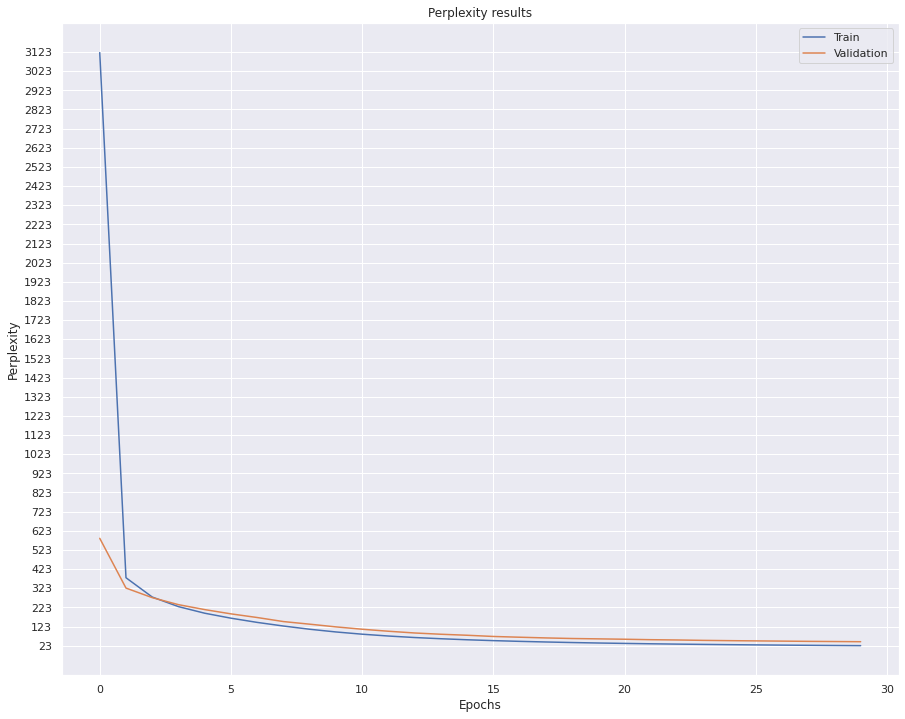

In [70]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['val_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Validation']);

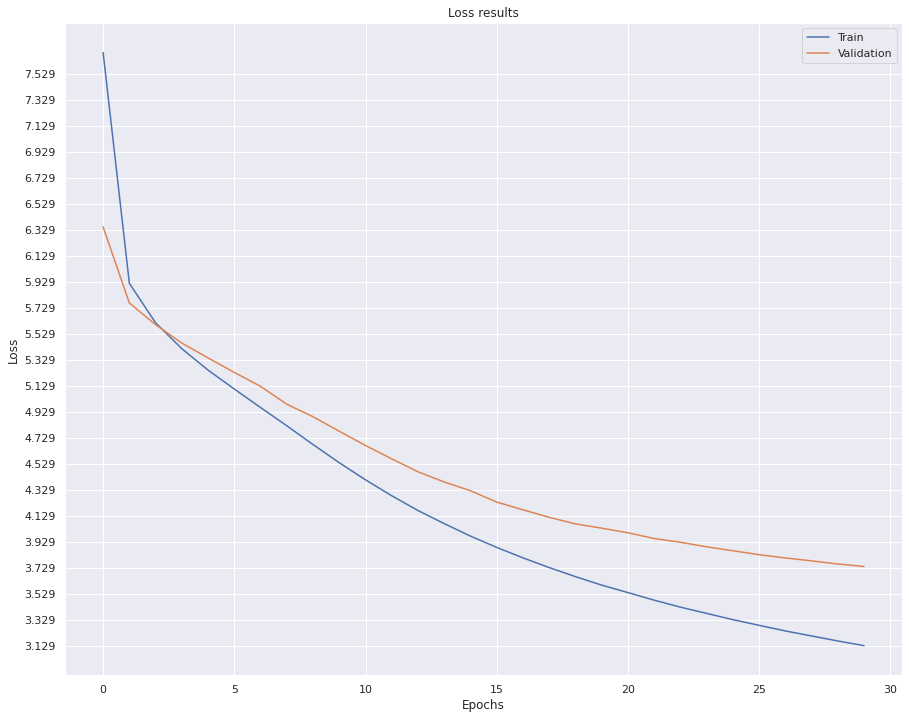

In [71]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['train_loss']),0.2))
plt.legend(['Train', 'Validation']);

# Testing model

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None,
                 units:int = 256):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token
        self.units = units

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 emo_encoder:tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 units:int = 256
                 ):
        
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len,
                         units
                         )
        self.emo_encoder = emo_encoder

    def decode(self, input, emo_feature, sentiment_feature):
        features = self.encoder(np.expand_dims(input, axis=0))
        emo_feature = np.expand_dims(emo_feature,axis=0)
        sentiment_feature = np.expand_dims(sentiment_feature, axis=0)
        hidden, state_c = self.emo_encoder(emo_feature)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, hidden, state_c, _ = self.decoder(target_seq,features,hidden,state_c,emo_feature,sentiment_feature)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [74]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                  emo_encoder:tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 units:int = 256
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len,
                         units
                         )
        self.emo_encoder = emo_encoder


    def decode(self, input, emo_feature,sentiment_feature, beam_size=3):
        start = [self.start_token]
        features = self.encoder(np.expand_dims(input,axis=0))
        sentiment_feature = np.expand_dims(sentiment_feature, axis=0)
        emo_feature = np.expand_dims(emo_feature,axis=0)
        hidden, state_c = self.emo_encoder(emo_feature)
        start_word = [[start, 0.0, hidden, state_c]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                hidden = s[-1]
                state_c = s[-2]
                output, hidden, state_c, _ = self.decoder(target_seq, features, hidden, state_c, emo_feature,sentiment_feature)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, hidden, state_c])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [75]:
def predict(data, emo_feature, sentiment_feature, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, emo_feature,sentiment_feature, beam_size=beam_size)
    else:
        result = decoder.decode(data, emo_feature,sentiment_feature)
    return ' '.join([inverse_vocab[i] for i in result])

In [112]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder,emotion_encoder, vocab[start_token], vocab[end_token],
             max_len=10, units=256)

In [113]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder,emotion_encoder, vocab[start_token], vocab[end_token],
             max_len=10, units=256)

In [114]:
images.shape

(3840, 224, 224, 3)

In [134]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

worried man is making a tattoo


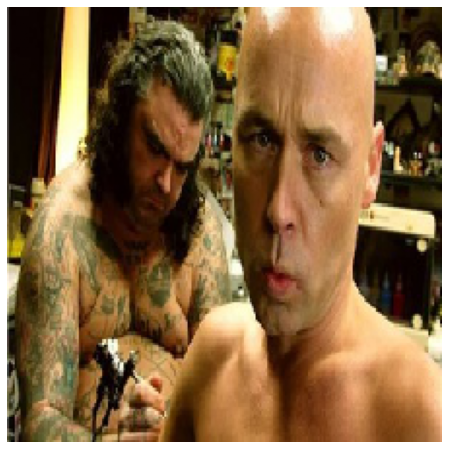

In [135]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [136]:
predict(sample, emotion_features[idx],sentiment[idx], greedy_decoder, inverse_vocab)

'the man is trying to the woman'

In [137]:
predict(sample,emotion_features[idx],sentiment[idx], beam_decoder, inverse_vocab, beam_size=3)

'the man is trying to shoot somebody'

In [138]:
predict(sample,emotion_features[idx], sentiment[idx], beam_decoder, inverse_vocab, beam_size=5)

'the man is trying to shoot somebody'

In [132]:
predict(sample,emotion_features[idx],sentiment[idx], beam_decoder, inverse_vocab, beam_size=7)

'the man is trying to harm somebody'

In [133]:
predict(sample,emotion_features[idx], sentiment[idx], beam_decoder, inverse_vocab, beam_size=10)

'the man is trying to harm somebody'

# Blue score calculation

In [139]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [141]:
test_predictions = []
for batch_image, batch_emo, batch_sentiment in tqdm(zip(test_images, test_emo, test_sen)):
    for image, emo, sen in zip(batch_image, batch_emo, batch_sentiment):
        result = predict(image, emo,sen, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

6it [04:12, 42.06s/it]


In [142]:
test_predictions = [i.split(' ') for i in test_predictions]

In [143]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [144]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [145]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

Overall bleu score on test data : 0.021284086038671806


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

In [146]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 1 : 0.2360973730812329


In [147]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 2 : 0.09082501344448422


In [148]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 3 : 0.042910169574204904


In [149]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 4 : 0.017241004338597304


In [150]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

Acuumulated bleu score on test data for n-gram = 4 : 0.021284086038671806


In [151]:
df.head()

,train_perplexity,val_perplexity,train_loss,val_loss,overall_bleu,n1_bleu,n2_bleu,n3_bleu,n4_bleu,acc_bleu
0,3086.377930,569.594421,7.676428,6.332008,2.128409,23.609737,9.082501,4.291017,1.7241,2.128409
1,363.907928,312.436127,5.880891,5.733656,2.128409,23.609737,9.082501,4.291017,1.7241,2.128409
2,270.553192,263.090240,5.590344,5.561590,2.128409,23.609737,9.082501,4.291017,1.7241,2.128409
3,218.950989,231.668884,5.379076,5.436800,2.128409,23.609737,9.082501,4.291017,1.7241,2.128409
4,187.503036,209.793213,5.223559,5.338082,2.128409,23.609737,9.082501,4.291017,1.7241,2.128409


In [152]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [93]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [94]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))